# Vehicle Detection Project Report

***

## Goal and Objective
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you apply color transform and append binned color features, to HOG feature vector. 
* Train a classifier to disinguish between car and non-car images
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run vehicle detection pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Model Training


## Training Data Preperation

### 1. Creating list of Cars and Not Cars

In [2]:
import glob
import time

# Divide up into cars and notcars
images = glob.glob('dataset/**/*.png', recursive=True)
cars = []
notcars = [] 
assert len(images) != 0
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)


### 2. Feature Extraction

In [ ]:
from utils.featureExtraction import *

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

C:\Users\iliatz\Miniconda3\envs\tf1_keras2_env\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


80.73 Seconds to extract features...


### 3. Feature Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### 4. Train-test Split

In [ ]:
# Split up data into randomized training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)

print('Feature vector length:', len(X_train[0]))

## Training

### 1. Training a LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

### 2. Testing Model Performance

In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

### 3. Sample Output

In [ ]:
from utils.featureExtraction import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

img = mpimg.imread('test_images/test1.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
plt.imshow(out_img)

## Storing Model and Parameters

In [ ]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)   

****
# Vehicle Detection

### 1.  HOG features

The code for HOG feature extraction can be found in `./utils/featureExtraction.py`.  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

([], <a list of 0 Text yticklabel objects>)

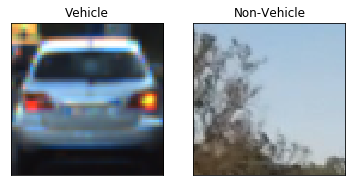

In [1]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

#plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
vehicle = plt.imread('dataset/vehicles/KITTI_extracted/200.png')
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
non_vehicle = plt.imread('dataset/non-vehicles/Extras/extra56.png')
plt.imshow(non_vehicle)
plt.title('Non-Vehicle')
plt.xticks([])
plt.yticks([])

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

C:\Users\iliatz\Miniconda3\envs\tf1_keras2_env\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([], <a list of 0 Text yticklabel objects>)

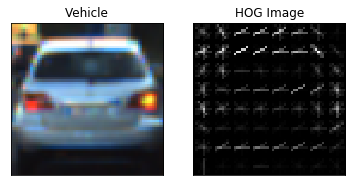

In [2]:
from utils.featureExtraction import *

plt.subplot(1,2,1)
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = get_hog_features(vehicle[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image')
plt.xticks([])
plt.yticks([])

### 2. Feature Extraction for Model

I tried various combinations of color spaces and parameters before finally settling with following:

```
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True
```

Increasing the orientation enhanced the accuarcy of the finally trained classifier, but increased the time required for computation.

The `color_space` was decided by training a classifier on different color spaces for spatial features, and `YCrCb` performed better than `RGB`, `HLS`, and `HSV`. 

### 3. Data Augmentation and Train-Test Split 

The images were fliped and added back to the directory containing original images as an augmentation step.

The `train_test_split` from `sklearn.model_selection` was used to randomized the data and make a 80-20% train-test split. The split was made so as to keep the ratio of vehicles and non-vehicles similar.

### 4. Model Training

The extracted features where fed to `LinearSVC` model of `sklearn` with default setting of `square-hinged` loss function and `l2` normalization. The trained model had accuracy of `99.47%` on test dataset. The SVC with rbf kernel performed better with accuracy of `99.78%` as compared to the LinearSVC but was very slow in predicting labels and hence was discarded.

The trained model along with the parameters used for training were written to a `pickle` file to be further used by vehicle detection pipeline.

** _Model training code can be above in block 2._ **

## Vehicle Detection Pipeline
---

### 1. Sliding Window Search
A single function, `find_cars` in `./utils/featureExtraction.py`, is used to extract features using hog sub-sampling and make predictions. The hog sub-sampling helps to reduce calculation time for finding HOG features and thus provided higher throughput rate. A sample output from the same is shown below.

Code with multi-scale window search and heatmap to reduce false positives have been implemented in the class `VehicleDetector` in `./utils/vehicle_detector.py` and is discussed in upcoming sections.

C:\Users\iliatz\Miniconda3\envs\tf1_keras2_env\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([], <a list of 0 Text yticklabel objects>)

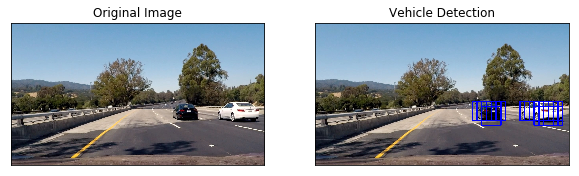

In [6]:
import pickle 

## Load model params
with open('model-params.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

img = mpimg.imread('test_images/test4.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(out_img)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])

### 2. Multi-Scale Search

The scale for the multi-window search and overlap to be considered was decided emperically.

The multi-scale window approach prevents calculation of feature vectors for the complete image and thus helps in speeding up the process. The following scales were emperically decided each having a overlap of `75%` (decided by `cells_per_step` which is set as `2`):


Scale 1:
```
ystart = 380
ystop = 480
scale = 1
```

Scale 2:
```
ystart = 400
ystop = 600
scale = 1.5
```

Scale 3:
```
ystart = 500
ystop = 700
scale = 2.5
```

The figure below shows the multiple scales under consideration overlapped on image.

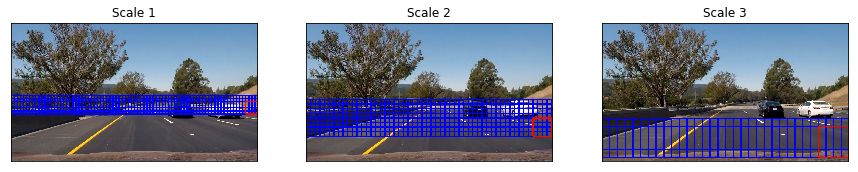

In [7]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img

img = mpimg.imread('test_images/test6.jpg')

plt.figure(figsize=(15,40))
subpltcount=1
for (ystart, ystop, scale) in [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]:
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

### 3. Avoiding False Positives and Label Detection

#### A. Hard Data Mining
Falsely detected patch were explicitly used to create a negative example added to training set. The false positives were avoided by using wrongly classified examples and adding it to the training dataset.

#### B. Feature Selection
Using `YCrCb` color space, the number of false positives were stemmed.

#### C. Heatmaps and Label Detection
I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

C:\Users\iliatz\Miniconda3\envs\tf1_keras2_env\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([], <a list of 0 Text yticklabel objects>)

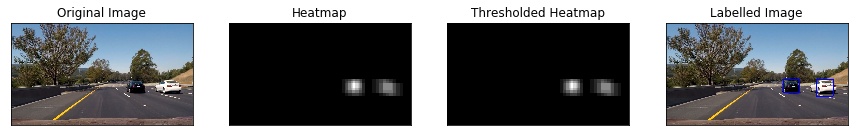

In [8]:
from utils.vehicle_detector import VehicleDetector
vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 3


img = mpimg.imread('test_images/test6.jpg')
out = vehicleDetector.find_cars(img)


plt.figure(figsize=(15,40))

## Input Image
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])


## Heatmap
plt.subplot(142)
heatmap = vehicleDetector.heat_images[0]
plt.imshow(heatmap, cmap='gray')
plt.title('Heatmap')
plt.xticks([])
plt.yticks([])

## Thresholded Heatmap
plt.subplot(143)
t_heatmap = vehicleDetector.heatmap
plt.imshow(heatmap, cmap='gray')
plt.title('Thresholded Heatmap')
plt.xticks([])
plt.yticks([])

## Label Detection
plt.subplot(144)
from scipy.ndimage.measurements import label
labels = label(t_heatmap)
labelled_image = np.copy(img)
VehicleDetector.draw_labeled_bboxes(labelled_image, labels)
plt.imshow(labelled_image)
plt.title('Labelled Image')
plt.xticks([])
plt.yticks([])

### 4. Search Optimization (Restricted Search)

The search was optimized by processing complete frames only once every 10 frames, and by having a restricted search in the remaining frames. The restricted search is performed by appending 50 pixel to the heatmap found in last three frames. Look at the implementation of `find_cars` method of `VehicleDetector` in `./utils/vehicle_detector.py`.

([], <a list of 0 Text yticklabel objects>)

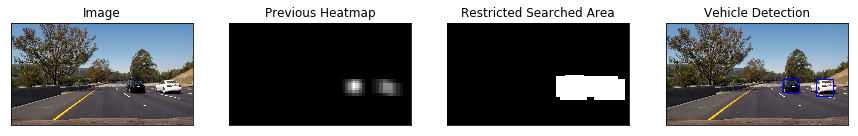

In [9]:
plt.figure(figsize=(15,50))
plt.subplot(141)
plt.imshow(img)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(heatmap, cmap='gray')
plt.title('Previous Heatmap')
plt.xticks([])
plt.yticks([])

plt.subplot(143)
mask = np.sum(np.array(vehicleDetector.heat_images), axis=0)
mask[(mask > 0)] = 1
mask = cv2.dilate(mask, vehicleDetector.kernel, iterations=1)
plt.imshow(mask, cmap='gray')
plt.title('Restricted Searched Area')
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(out)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])

## Video Implementation
---

### 1. Vehicle Detection
The youtube video of the final implementation can be accessed by clicking the following image link.

[![VehicleDetection](http://img.youtube.com/vi/cpCwpOtWZs8/0.jpg)](http://www.youtube.com/watch?v=cpCwpOtWZs8)

In [10]:
from utils.vehicle_detector import VehicleDetector
vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 3

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output_without_lanes.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(vehicleDetector.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


[MoviePy] >>>> Building video project_video_output_without_lanes.mp4
[MoviePy] Writing video project_video_output_without_lanes.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_without_lanes.mp4 

Wall time: 7min 35s


## Discussion
---

A neural network based model like ssd or yolo might provided better results for  feature detection the classification for vehicles.
The developed pipeline may possibly fail in varied lighting and illumination conditions. Also, the multi-window search may be optimized further for better speed and accuracy.